# Face Recognition Model Comparison
## Comprehensive Analysis: PCA/Eigenfaces, LBPH, MobileFaceNet, and EfficientNet

This notebook combines and compares 4 different face recognition approaches:
1. **PCA(Eigenfaces)** - Classical dimensionality reduction approach
2. **LBPH** - Traditional Local Binary Pattern Histograms
3. **MobileFaceNet + ArcFace** - Lightweight CNN with metric learning
4. **EfficientNet-B0 + ArcFace** - Transfer learning approach

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score
from PIL import Image
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All imports successful!
PyTorch version: 2.9.1+cu126
CUDA available: True


## 2. Dataset Loading and Exploration

In [2]:
dataset_root = 'VGGFace2'
full_dataset = datasets.ImageFolder(dataset_root)

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Dataset path: {dataset_root}")
print(f"Total images: {len(full_dataset)}")
print(f"Total classes (identities): {len(full_dataset.classes)}")

DATASET OVERVIEW
Dataset path: VGGFace2
Total images: 56352
Total classes (identities): 126


In [3]:
num_classes = 10
all_labels = np.array(full_dataset.targets)
selected_indices = np.where(all_labels < num_classes)[0]
unique_class_ids = sorted(np.unique(all_labels[selected_indices]))
class_id_map = {orig_id: new_id for new_id, orig_id in enumerate(unique_class_ids)}
labels = np.array([class_id_map[l] for l in all_labels[selected_indices]])
class_names = [full_dataset.classes[i] for i in unique_class_ids]
selected_paths = [full_dataset.samples[i][0] for i in selected_indices]

print("\n" + "=" * 60)
print("SELECTED CLASSES FOR EXPERIMENT")
print("=" * 60)
for i, class_name in enumerate(class_names):
    count = np.sum(labels == i)
    print(f"Class {i}: {class_name:<45} ({count:>4} images)")
print("=" * 60)
print(f"Total: {num_classes} classes, {len(selected_indices)} images")


SELECTED CLASSES FOR EXPERIMENT
Class 0: class1                                        ( 485 images)
Class 1: class10                                       ( 450 images)
Class 2: class100                                      ( 422 images)
Class 3: class101                                      ( 452 images)
Class 4: class102                                      ( 415 images)
Class 5: class103                                      ( 454 images)
Class 6: class104                                      ( 402 images)
Class 7: class105                                      ( 491 images)
Class 8: class106                                      ( 470 images)
Class 9: class107                                      ( 420 images)
Total: 10 classes, 4461 images


## 3. Dataset Visualization

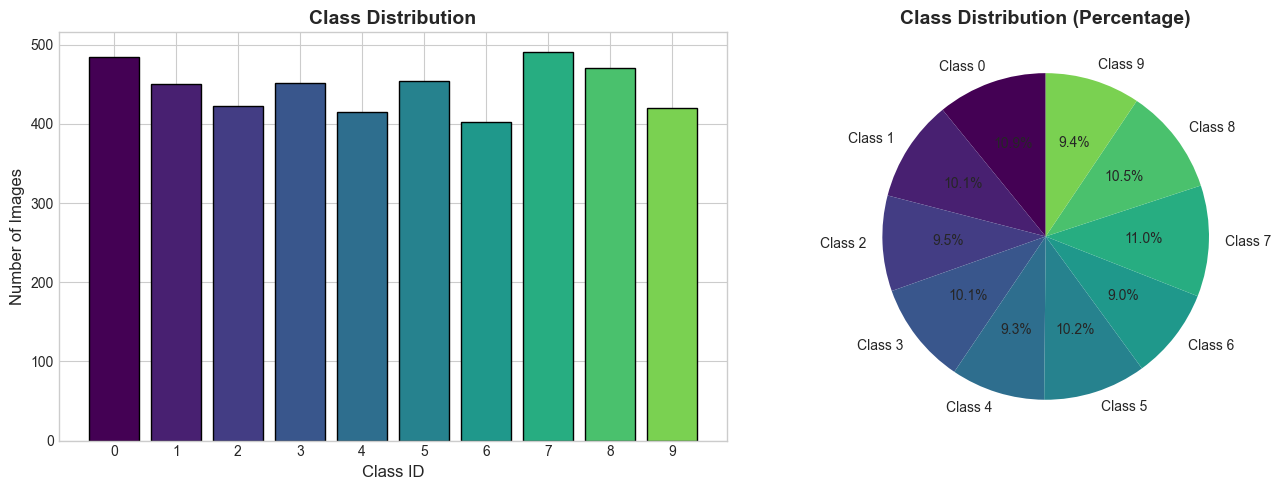

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
class_counts = [np.sum(labels == i) for i in range(num_classes)]
colors = plt.cm.viridis(np.linspace(0, 0.8, num_classes))

axes[0].bar(range(num_classes), class_counts, color=colors, edgecolor='black')
axes[0].set_xlabel('Class ID', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(num_classes))

axes[1].pie(class_counts, labels=[f'Class {i}' for i in range(num_classes)], 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

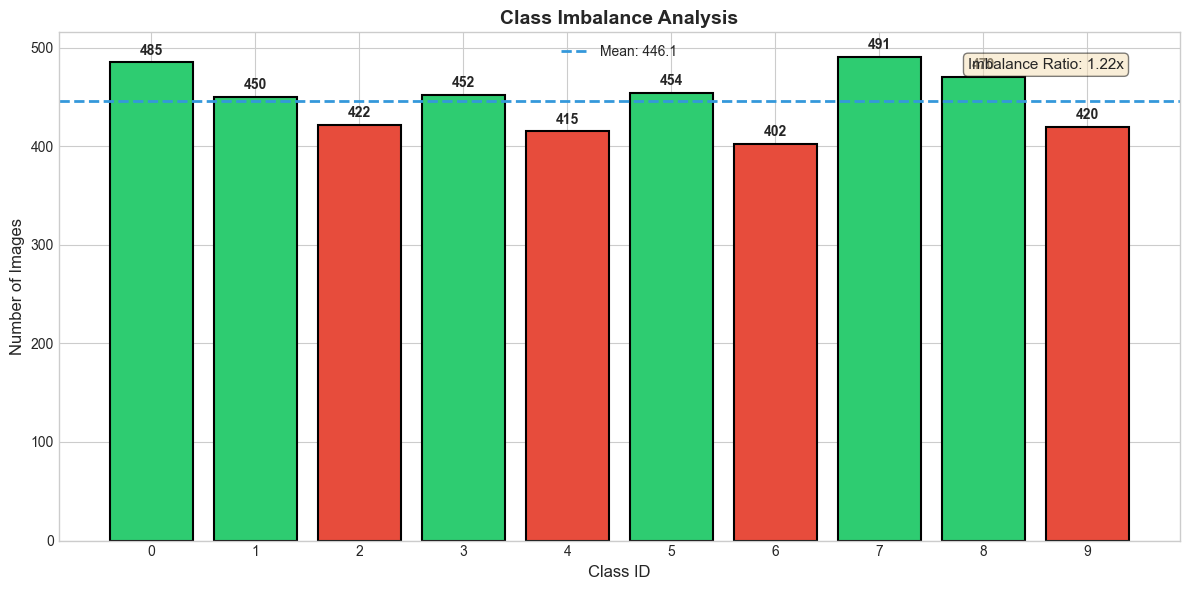

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
mean_count = np.mean(class_counts)
bar_colors = ['#2ecc71' if c >= mean_count else '#e74c3c' for c in class_counts]
bars = ax.bar(range(num_classes), class_counts, color=bar_colors, edgecolor='black', linewidth=1.5)
ax.axhline(y=mean_count, color='#3498db', linestyle='--', linewidth=2, label=f'Mean: {mean_count:.1f}')
for bar, count in zip(bars, class_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.set_xlabel('Class ID', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Class Imbalance Analysis', fontsize=14, fontweight='bold')
ax.set_xticks(range(num_classes))
ax.legend()
imbalance_ratio = max(class_counts) / min(class_counts)
ax.text(0.95, 0.95, f'Imbalance Ratio: {imbalance_ratio:.2f}x', transform=ax.transAxes, ha='right', va='top', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig('class_imbalance_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

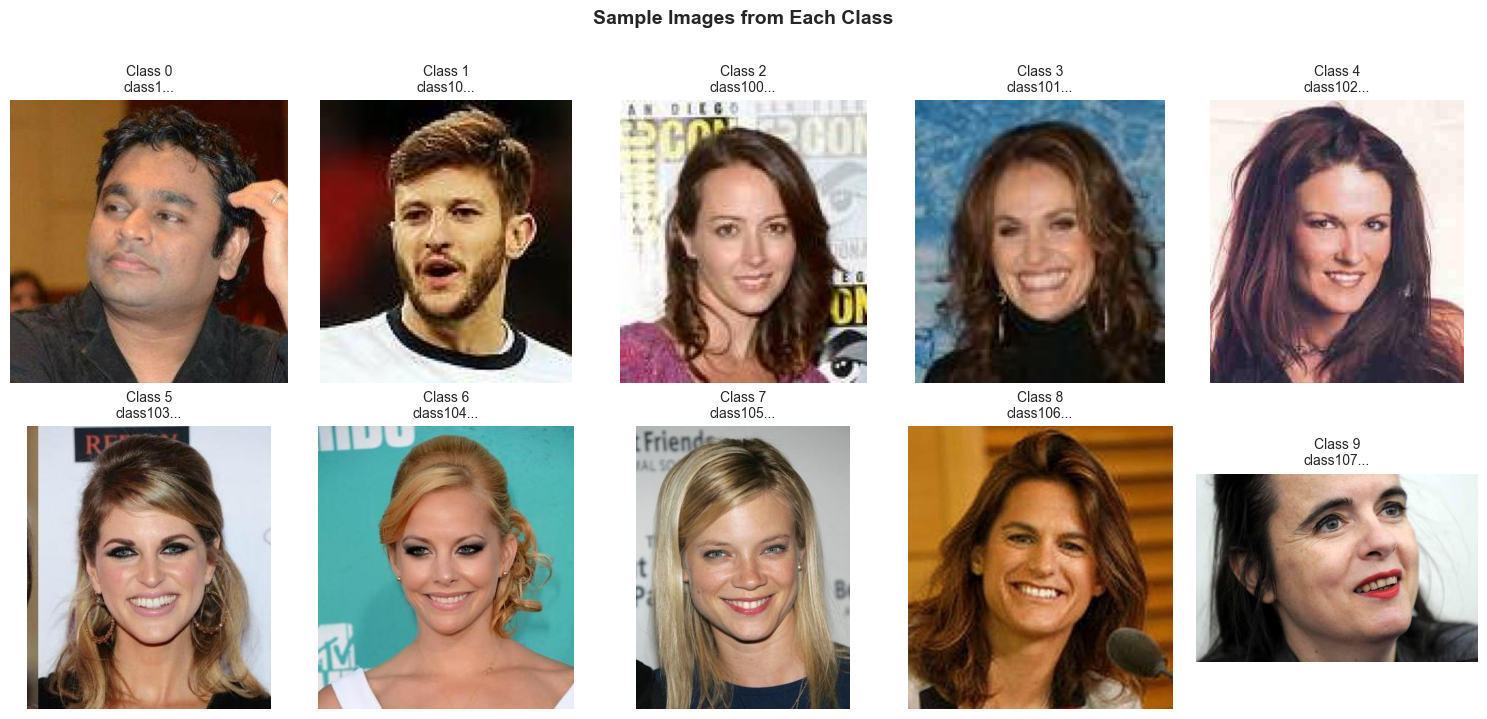

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.flatten()
for i in range(num_classes):
    class_indices = np.where(labels == i)[0]
    img_path = selected_paths[class_indices[0]]
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f'Class {i}\n{class_names[i][:20]}...', fontsize=10)
    axes[i].axis('off')
plt.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_images_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Train/Test Split

In [7]:
train_indices, test_indices = train_test_split(np.arange(len(selected_paths)), test_size=0.2, random_state=42, stratify=labels)
train_paths = [selected_paths[i] for i in train_indices]
test_paths = [selected_paths[i] for i in test_indices]
y_train = labels[train_indices]
y_test = labels[test_indices]

print("=" * 70)
print("TRAIN/TEST SPLIT SUMMARY")
print("=" * 70)
print(f"{'Class ID':<10} {'Class Name':<40} {'Train':<10} {'Test':<10} {'Total':<10}")
print("-" * 70)
for i in range(num_classes):
    train_count = np.sum(y_train == i)
    test_count = np.sum(y_test == i)
    total_count = train_count + test_count
    print(f"{i:<10} {class_names[i][:38]:<40} {train_count:<10} {test_count:<10} {total_count:<10}")
print("-" * 70)
print(f"{'TOTAL':<10} {'':<40} {len(train_paths):<10} {len(test_paths):<10} {len(selected_paths):<10}")
print("=" * 70)

TRAIN/TEST SPLIT SUMMARY
Class ID   Class Name                               Train      Test       Total     
----------------------------------------------------------------------
0          class1                                   388        97         485       
1          class10                                  360        90         450       
2          class100                                 337        85         422       
3          class101                                 361        91         452       
4          class102                                 332        83         415       
5          class103                                 363        91         454       
6          class104                                 322        80         402       
7          class105                                 393        98         491       
8          class106                                 376        94         470       
9          class107                                 33

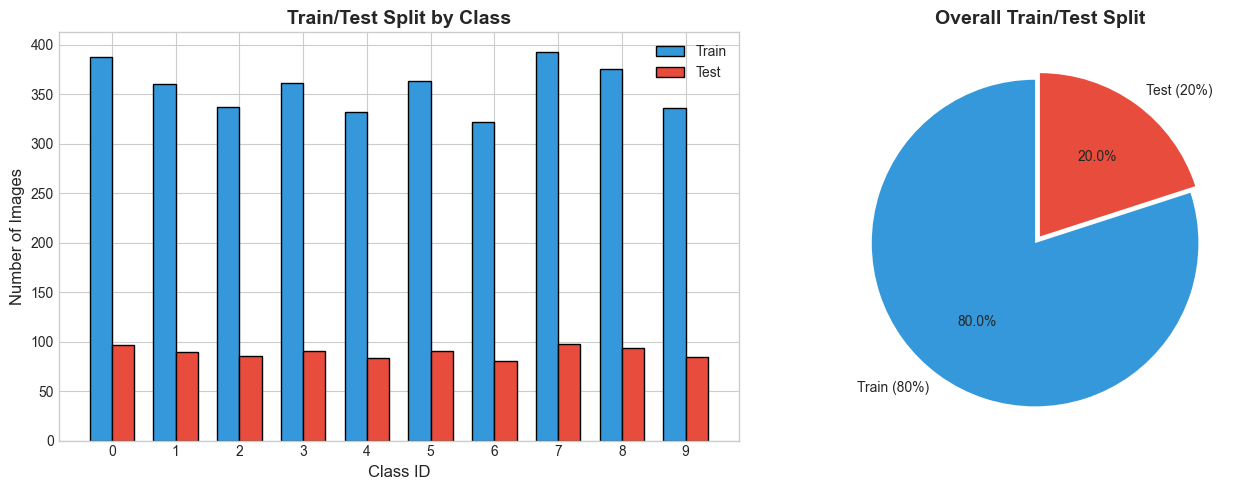

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_counts = [np.sum(y_train == i) for i in range(num_classes)]
test_counts = [np.sum(y_test == i) for i in range(num_classes)]
x = np.arange(num_classes)
width = 0.35
axes[0].bar(x - width/2, train_counts, width, label='Train', color='#3498db', edgecolor='black')
axes[0].bar(x + width/2, test_counts, width, label='Test', color='#e74c3c', edgecolor='black')
axes[0].set_xlabel('Class ID', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_title('Train/Test Split by Class', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].legend()
axes[1].pie([len(train_paths), len(test_paths)], labels=['Train (80%)', 'Test (20%)'], autopct='%1.1f%%', colors=['#3498db', '#e74c3c'], explode=[0.05, 0], startangle=90)
axes[1].set_title('Overall Train/Test Split', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('train_test_split_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Model Architectures Definition

In [9]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride):
        super().__init__()
        expanded_channels = in_channels * expansion
        self.use_residual = stride == 1 and in_channels == out_channels
        self.conv1 = nn.Conv2d(in_channels, expanded_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(expanded_channels)
        self.prelu1 = nn.PReLU(expanded_channels)
        self.dwconv = nn.Conv2d(expanded_channels, expanded_channels, kernel_size=3, stride=stride, padding=1, groups=expanded_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(expanded_channels)
        self.prelu2 = nn.PReLU(expanded_channels)
        self.conv3 = nn.Conv2d(expanded_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.prelu1(self.bn1(self.conv1(x)))
        out = self.prelu2(self.bn2(self.dwconv(out)))
        out = self.bn3(self.conv3(out))
        if self.use_residual:
            out = out + x
        return out

class MobileFaceNet(nn.Module):
    def __init__(self, embedding_size=512):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu1 = nn.PReLU(64)
        self.dwconv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64, bias=False)
        self.bn_dw1 = nn.BatchNorm2d(64)
        self.prelu_dw1 = nn.PReLU(64)
        self.bottlenecks = nn.Sequential(
            Bottleneck(64, 64, expansion=2, stride=2),
            *[Bottleneck(64, 64, expansion=2, stride=1) for _ in range(4)],
            Bottleneck(64, 128, expansion=4, stride=2),
            *[Bottleneck(128, 128, expansion=2, stride=1) for _ in range(6)],
            Bottleneck(128, 128, expansion=4, stride=2),
            *[Bottleneck(128, 128, expansion=2, stride=1) for _ in range(2)],
        )
        self.conv_last = nn.Conv2d(128, 512, kernel_size=1, bias=False)
        self.bn_last = nn.BatchNorm2d(512)
        self.prelu_last = nn.PReLU(512)
        self.gdconv = nn.Conv2d(512, 512, kernel_size=7, groups=512, bias=False)
        self.bn_gd = nn.BatchNorm2d(512)
        self.linear = nn.Linear(512, embedding_size, bias=False)
        self.bn_embed = nn.BatchNorm1d(embedding_size)

    def forward(self, x):
        out = self.prelu1(self.bn1(self.conv1(x)))
        out = self.prelu_dw1(self.bn_dw1(self.dwconv1(out)))
        out = self.bottlenecks(out)
        out = self.prelu_last(self.bn_last(self.conv_last(out)))
        out = self.bn_gd(self.gdconv(out))
        out = out.view(out.size(0), -1)
        out = self.bn_embed(self.linear(out))
        return out

print("MobileFaceNet architecture defined!")

MobileFaceNet architecture defined!


In [10]:
class EfficientNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        efficientnet = models.efficientnet_b0(pretrained=False)
        self.features = efficientnet.features
        self.pool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return x

print("EfficientNet backbone defined!")

EfficientNet backbone defined!


In [11]:
class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
print("Dataset class and transforms defined!")

Dataset class and transforms defined!


## 6. Load Pre-trained Models

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("\n" + "="*50)
print("Loading PCA/Eigenfaces model...")
pca_data = np.load('best_eigenfaces.npz', allow_pickle=True)
pca_mean = pca_data['mean']
pca_W = pca_data['W']
print(f"   PCA components: {pca_W.shape[1]}")
print("[OK] PCA/Eigenfaces loaded successfully!")

Using device: cuda

Loading PCA/Eigenfaces model...
   PCA components: 250
[OK] PCA/Eigenfaces loaded successfully!


In [13]:
print("\n" + "="*50)
print("Loading LBPH model...")
lbph = cv2.face.LBPHFaceRecognizer_create()
lbph.read('lbph_fixed.yml')
print("[OK] LBPH loaded successfully!")


Loading LBPH model...
[OK] LBPH loaded successfully!


In [14]:
print("\n" + "="*50)
print("Loading MobileFaceNet model...")
mobilefacenet = MobileFaceNet(embedding_size=512).to(device)
mobilefacenet.load_state_dict(torch.load('another_one_mobilefacenet_arcface.pth', map_location=device))
mobilefacenet.eval()
print("[OK] MobileFaceNet loaded successfully!")


Loading MobileFaceNet model...
[OK] MobileFaceNet loaded successfully!


In [15]:
print("\n" + "="*50)
print("Loading EfficientNet model...")
efficientnet = EfficientNetBackbone().to(device)
state_dict = torch.load('efficientnet_b0_arcface_fixed.pth', map_location=device)
backbone_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("backbone.") or k.startswith("features.") or k.startswith("pool."):
        new_k = k.replace("backbone.", "features.", 1) if "backbone." in k else k
        backbone_state_dict[new_k] = v
efficientnet.load_state_dict(backbone_state_dict, strict=True)
efficientnet.eval()
print("[OK] EfficientNet loaded successfully!")
print("\n" + "="*50)
print("ALL MODELS LOADED SUCCESSFULLY!")
print("="*50)


Loading EfficientNet model...
[OK] EfficientNet loaded successfully!

ALL MODELS LOADED SUCCESSFULLY!


## 7. Evaluation Functions

In [16]:
train_dataset = FaceDataset(train_paths, y_train, test_transform)
test_dataset = FaceDataset(test_paths, y_test, test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def extract_embeddings_pytorch(model, loader):
    embs, lbls = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            emb = model(imgs)
            emb = F.normalize(emb, dim=1)
            embs.append(emb.cpu().numpy())
            lbls.extend(labels.numpy())
    return np.vstack(embs), np.array(lbls)

def compute_all_metrics(embeddings, labels, gallery_emb, gallery_labels, n_pairs=2000):
    metrics = {}
    same, diff = [], []
    np.random.seed(42)
    for _ in range(n_pairs):
        lbl = np.random.choice(np.unique(labels))
        idxs = np.where(labels == lbl)[0]
        if len(idxs) >= 2:
            i, j = np.random.choice(idxs, 2, replace=False)
            same.append(np.dot(embeddings[i], embeddings[j]))
        l1, l2 = np.random.choice(np.unique(labels), 2, replace=False)
        i = np.random.choice(np.where(labels == l1)[0])
        j = np.random.choice(np.where(labels == l2)[0])
        diff.append(np.dot(embeddings[i], embeddings[j]))
    sims = np.array(same + diff)
    pair_labels = np.array([1]*len(same) + [0]*len(diff))
    metrics['Verification AUC'] = roc_auc_score(pair_labels, sims)
    fpr, tpr, thresholds = roc_curve(pair_labels, sims)
    J = tpr - fpr
    best_idx = np.argmax(J)
    best_thresh = thresholds[best_idx]
    preds_ver = (sims > best_thresh).astype(int)
    metrics['Verification Accuracy'] = accuracy_score(pair_labels, preds_ver)
    metrics['Verification Precision'] = precision_score(pair_labels, preds_ver)
    metrics['Verification Recall'] = recall_score(pair_labels, preds_ver)
    metrics['Verification F1'] = f1_score(pair_labels, preds_ver)
    similarity_matrix = np.dot(embeddings, gallery_emb.T)
    preds = np.argmax(similarity_matrix, axis=1)
    pred_labels = gallery_labels[preds]
    metrics['Rank-1 Accuracy'] = np.mean(pred_labels == labels)
    metrics['Identification Precision'] = precision_score(labels, pred_labels, average='weighted', zero_division=0)
    metrics['Identification Recall'] = recall_score(labels, pred_labels, average='weighted', zero_division=0)
    metrics['Identification F1'] = f1_score(labels, pred_labels, average='weighted', zero_division=0)
    mse_scores = []
    for i in range(len(embeddings)):
        correct_idx = np.where(gallery_labels == labels[i])[0]
        if len(correct_idx) > 0:
            target = gallery_emb[correct_idx[0]]
            mse_scores.append(mean_squared_error(embeddings[i], target))
    metrics['MSE'] = np.mean(mse_scores) if mse_scores else 0
    return metrics

print("Evaluation functions defined!")

Evaluation functions defined!


## 8. Evaluate All Models

In [17]:
results = {}

In [18]:
print("\n" + "="*60)
print("EVALUATING: 1. PCA/Eigenfaces")
print("="*60)
def load_pca_images(paths):
    images = []
    for path in paths:
        img = Image.open(path).convert('L')
        img = img.resize((112, 112))
        x = np.array(img).flatten().astype(np.float32)
        x = (x - 127.5) / 128.0
        images.append(x)
    return np.array(images)

X_train_pca = load_pca_images(train_paths)
X_test_pca = load_pca_images(test_paths)
train_feats_pca = (X_train_pca - pca_mean) @ pca_W
test_feats_pca = (X_test_pca - pca_mean) @ pca_W
train_feats_pca = train_feats_pca / np.linalg.norm(train_feats_pca, axis=1, keepdims=True)
test_feats_pca = test_feats_pca / np.linalg.norm(test_feats_pca, axis=1, keepdims=True)
results['PCA/Eigenfaces'] = compute_all_metrics(test_feats_pca, y_test, train_feats_pca, y_train)
print("Results:")
for k, v in results['PCA/Eigenfaces'].items():
    print(f"   {k}: {v:.4f}")


EVALUATING: 1. PCA/Eigenfaces
Results:
   Verification AUC: 0.5781
   Verification Accuracy: 0.5613
   Verification Precision: 0.5499
   Verification Recall: 0.6750
   Verification F1: 0.6061
   Rank-1 Accuracy: 0.4681
   Identification Precision: 0.4683
   Identification Recall: 0.4681
   Identification F1: 0.4654
   MSE: 0.0075


In [19]:
print("\n" + "="*60)
print("EVALUATING: 2. LBPH (Local Binary Pattern Histograms)")
print("="*60)
IMG_SIZE = 80
def load_lbph_images(paths):
    images = []
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.equalizeHist(img)
        images.append(img)
    return images

test_images_lbph = load_lbph_images(test_paths)
preds_lbph, confs_lbph = [], []
for img in test_images_lbph:
    label, conf = lbph.predict(img)
    preds_lbph.append(label)
    confs_lbph.append(conf)

rank1_lbph = accuracy_score(y_test, preds_lbph)
n_pairs = 1000
same_lbph, diff_lbph = [], []
np.random.seed(42)
for _ in range(n_pairs):
    lbl = np.random.choice(np.unique(y_test))
    idxs = np.where(y_test == lbl)[0]
    if len(idxs) >= 2:
        i, j = np.random.choice(idxs, 2, replace=False)
        same_lbph.append(abs(confs_lbph[i] - confs_lbph[j]))
    l1, l2 = np.random.choice(np.unique(y_test), 2, replace=False)
    i = np.random.choice(np.where(y_test == l1)[0])
    j = np.random.choice(np.where(y_test == l2)[0])
    diff_lbph.append(abs(confs_lbph[i] - confs_lbph[j]))

dists_lbph = np.array(same_lbph + diff_lbph)
labels_lbph = np.array([1]*len(same_lbph) + [0]*len(diff_lbph))
auc_lbph = roc_auc_score(labels_lbph, -dists_lbph)

results['LBPH'] = {
    'Verification AUC': auc_lbph,
    'Verification Accuracy': rank1_lbph,
    'Verification Precision': precision_score(y_test, preds_lbph, average='weighted', zero_division=0),
    'Verification Recall': recall_score(y_test, preds_lbph, average='weighted', zero_division=0),
    'Verification F1': f1_score(y_test, preds_lbph, average='weighted', zero_division=0),
    'Rank-1 Accuracy': rank1_lbph,
    'Identification Precision': precision_score(y_test, preds_lbph, average='weighted', zero_division=0),
    'Identification Recall': recall_score(y_test, preds_lbph, average='weighted', zero_division=0),
    'Identification F1': f1_score(y_test, preds_lbph, average='weighted', zero_division=0),
    'MSE': np.mean(confs_lbph)
}
print("Results:")
for k, v in results['LBPH'].items():
    print(f"   {k}: {v:.4f}")


EVALUATING: 2. LBPH (Local Binary Pattern Histograms)
Results:
   Verification AUC: 0.5249
   Verification Accuracy: 0.5722
   Verification Precision: 0.5928
   Verification Recall: 0.5722
   Verification F1: 0.5745
   Rank-1 Accuracy: 0.5722
   Identification Precision: 0.5928
   Identification Recall: 0.5722
   Identification F1: 0.5745
   MSE: 28.6963


In [20]:
print("\n" + "="*60)
print("EVALUATING: 3. MobileFaceNet + ArcFace")
print("="*60)
train_emb_mfn, _ = extract_embeddings_pytorch(mobilefacenet, train_loader)
test_emb_mfn, test_lbl_mfn = extract_embeddings_pytorch(mobilefacenet, test_loader)
results['MobileFaceNet'] = compute_all_metrics(test_emb_mfn, test_lbl_mfn, train_emb_mfn, y_train)
print("Results:")
for k, v in results['MobileFaceNet'].items():
    print(f"   {k}: {v:.4f}")


EVALUATING: 3. MobileFaceNet + ArcFace
Results:
   Verification AUC: 0.8018
   Verification Accuracy: 0.7350
   Verification Precision: 0.7635
   Verification Recall: 0.6810
   Verification F1: 0.7199
   Rank-1 Accuracy: 0.8645
   Identification Precision: 0.8660
   Identification Recall: 0.8645
   Identification F1: 0.8647
   MSE: 0.0013


In [21]:
print("\n" + "="*60)
print("EVALUATING: 4. EfficientNet-B0 + ArcFace")
print("="*60)
train_emb_eff, _ = extract_embeddings_pytorch(efficientnet, train_loader)
test_emb_eff, test_lbl_eff = extract_embeddings_pytorch(efficientnet, test_loader)
results['EfficientNet'] = compute_all_metrics(test_emb_eff, test_lbl_eff, train_emb_eff, y_train)
print("Results:")
for k, v in results['EfficientNet'].items():
    print(f"   {k}: {v:.4f}")


EVALUATING: 4. EfficientNet-B0 + ArcFace
Results:
   Verification AUC: 0.9388
   Verification Accuracy: 0.8698
   Verification Precision: 0.8957
   Verification Recall: 0.8370
   Verification F1: 0.8653
   Rank-1 Accuracy: 0.9406
   Identification Precision: 0.9414
   Identification Recall: 0.9406
   Identification F1: 0.9407
   MSE: 0.0009


## 9. Model Comparison and Visualization

In [22]:
print("\n" + "="*100)
print("                           MODEL COMPARISON SUMMARY")
print("="*100)
metric_keys = list(list(results.values())[0].keys())
header = f"{'Model':<20}"
for key in metric_keys:
    header += f"{key:<18}"
print(header)
print("-"*100)
for model, metrics in results.items():
    row = f"{model:<20}"
    for key in metric_keys:
        row += f"{metrics.get(key, 0):<18.4f}"
    print(row)
print("="*100)
best_model = max(results.keys(), key=lambda x: results[x]['Rank-1 Accuracy'])
print(f"\nBest Model (by Rank-1 Accuracy): {best_model}")


                           MODEL COMPARISON SUMMARY
Model               Verification AUC  Verification AccuracyVerification PrecisionVerification RecallVerification F1   Rank-1 Accuracy   Identification PrecisionIdentification RecallIdentification F1 MSE               
----------------------------------------------------------------------------------------------------
PCA/Eigenfaces      0.5781            0.5613            0.5499            0.6750            0.6061            0.4681            0.4683            0.4681            0.4654            0.0075            
LBPH                0.5249            0.5722            0.5928            0.5722            0.5745            0.5722            0.5928            0.5722            0.5745            28.6963           
MobileFaceNet       0.8018            0.7350            0.7635            0.6810            0.7199            0.8645            0.8660            0.8645            0.8647            0.0013            
EfficientNet        0.938

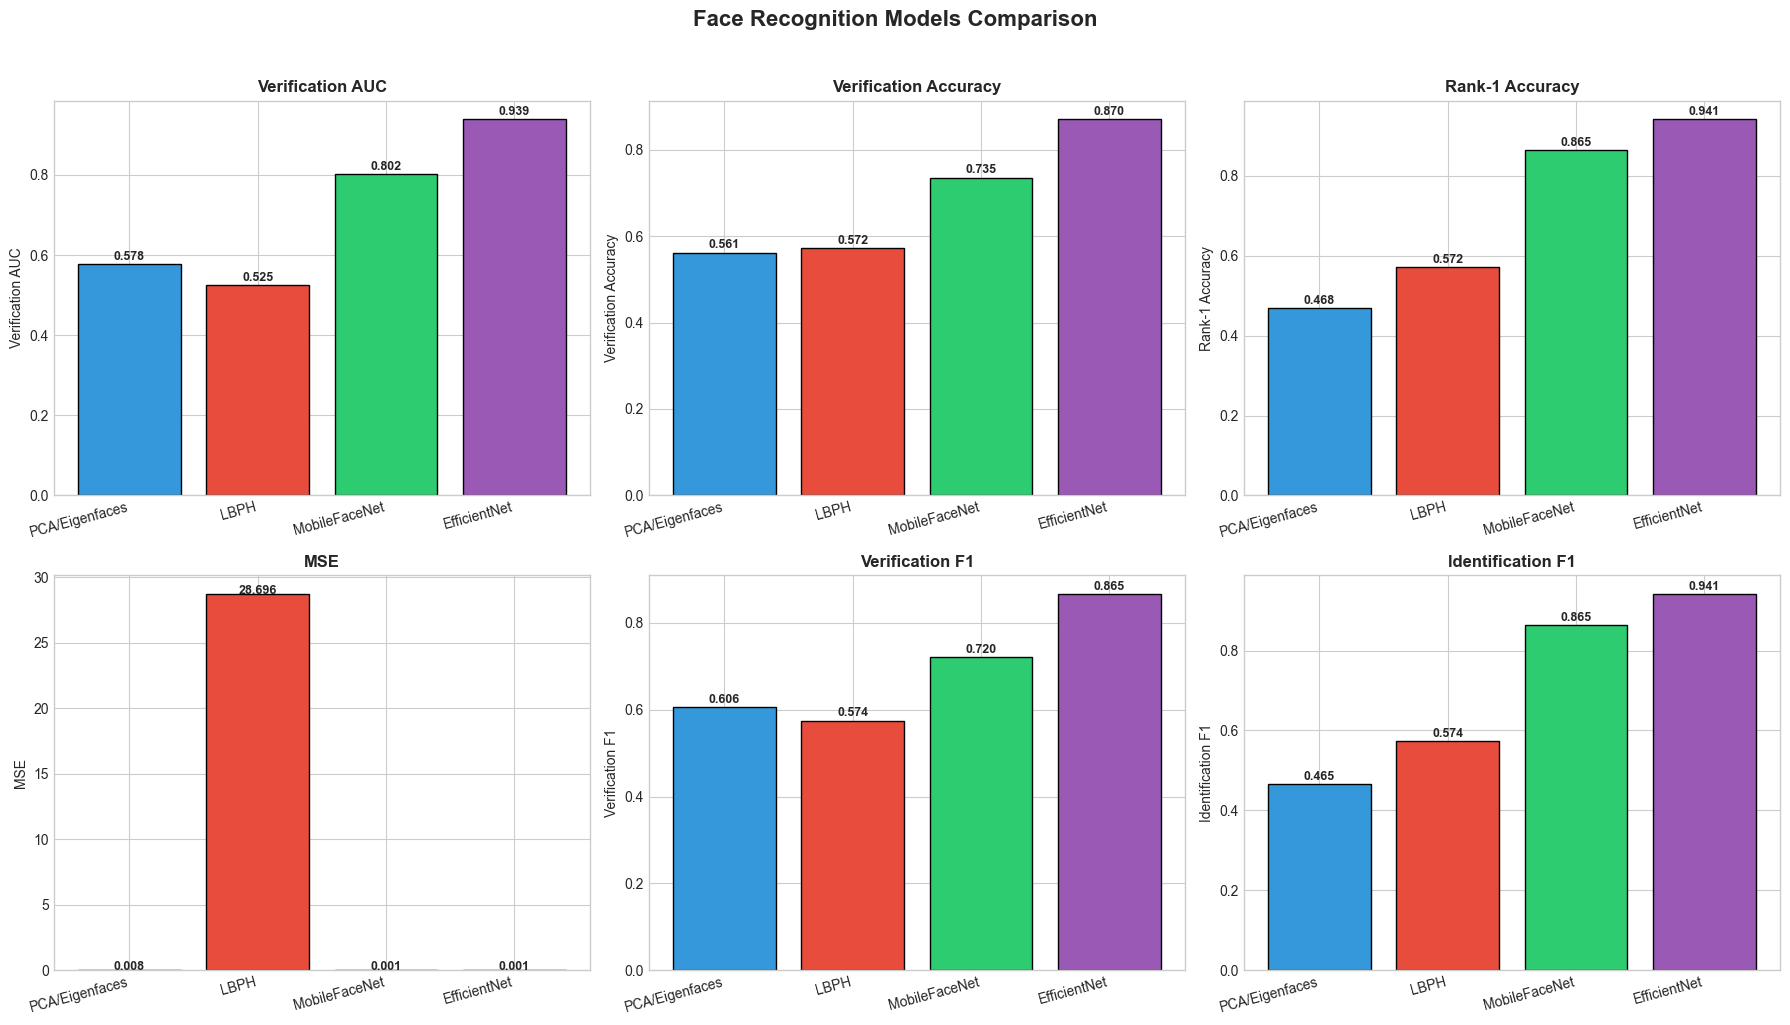

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
models_list = list(results.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

metrics_to_plot = ['Verification AUC', 'Verification Accuracy', 'Rank-1 Accuracy', 'MSE', 'Verification F1', 'Identification F1']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx//3, idx%3]
    vals = [results[m].get(metric, 0) for m in models_list]
    bars = ax.bar(models_list, vals, color=colors, edgecolor='black')
    ax.set_ylabel(metric, fontsize=10)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.set_xticklabels(models_list, rotation=15, ha='right')

plt.suptitle('Face Recognition Models Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('final_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

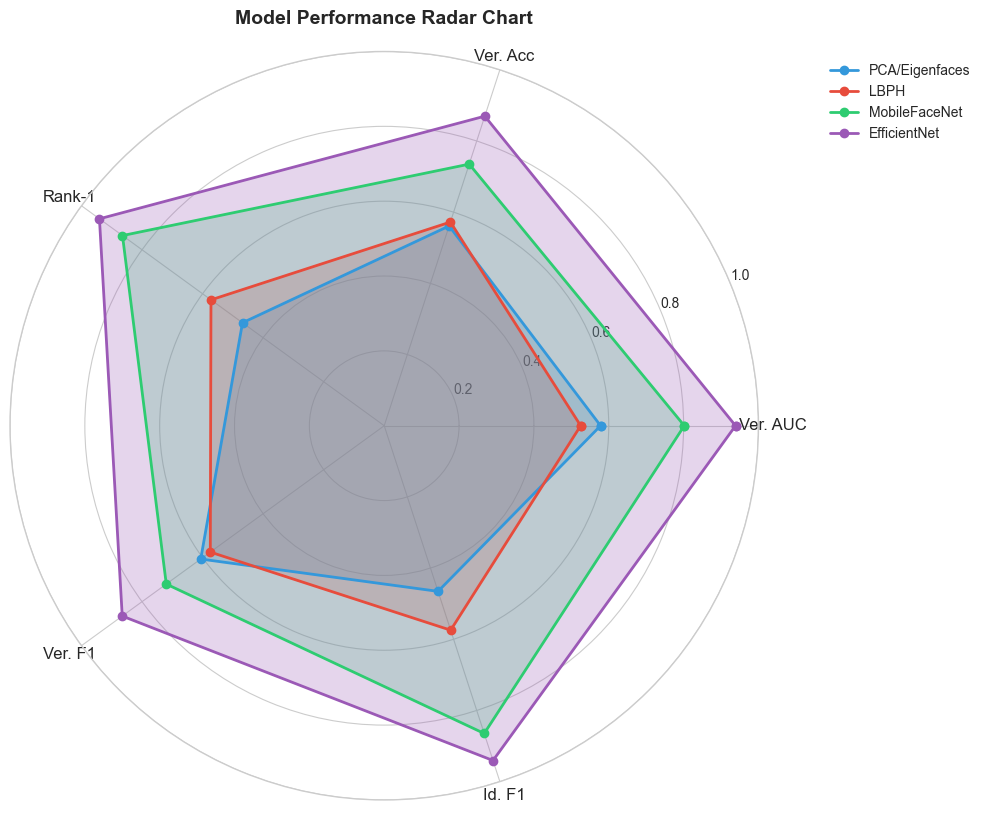

In [24]:
categories = ['Ver. AUC', 'Ver. Acc', 'Rank-1', 'Ver. F1', 'Id. F1']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for model, color in zip(models_list, colors):
    values = [results[model]['Verification AUC'], results[model]['Verification Accuracy'],
              results[model]['Rank-1 Accuracy'], results[model]['Verification F1'],
              results[model]['Identification F1']]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title('Model Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('model_radar_chart.png', dpi=150, bbox_inches='tight')
plt.show()

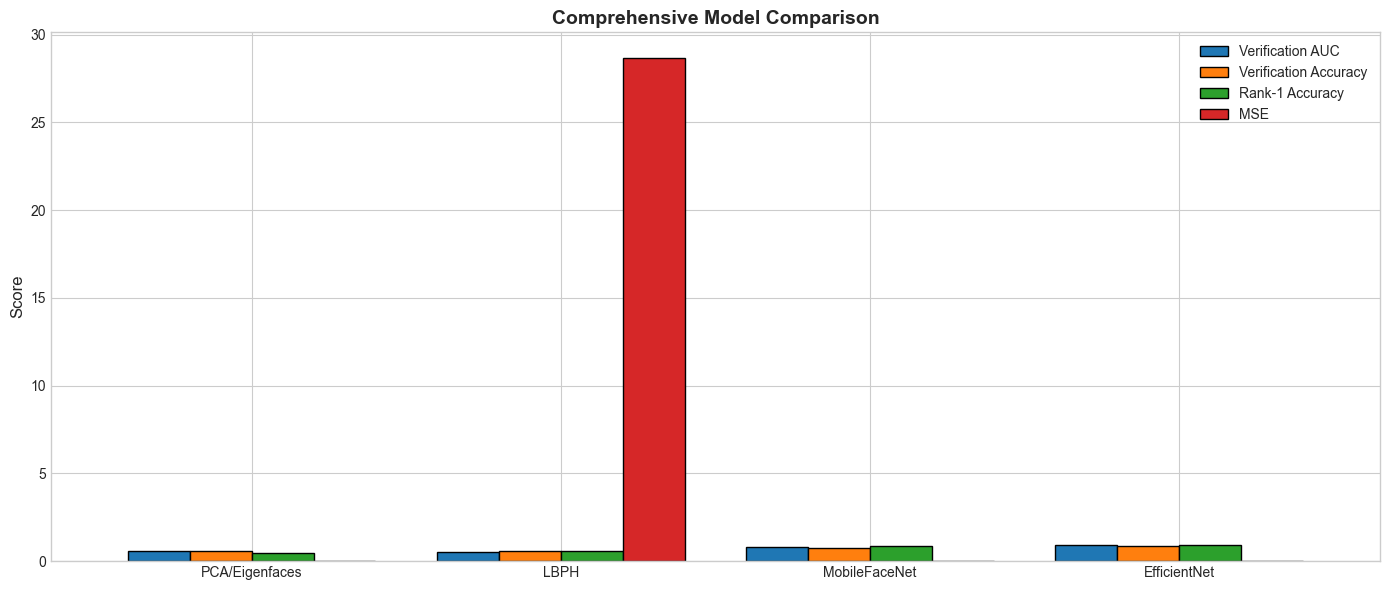

In [25]:
import pandas as pd
df = pd.DataFrame(results).T
fig, ax = plt.subplots(figsize=(14, 6))
df_subset = df[['Verification AUC', 'Verification Accuracy', 'Rank-1 Accuracy', 'MSE']]
df_subset.plot(kind='bar', ax=ax, edgecolor='black', width=0.8)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comprehensive Model Comparison', fontsize=14, fontweight='bold')
ax.set_xticklabels(df_subset.index, rotation=0)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('comprehensive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

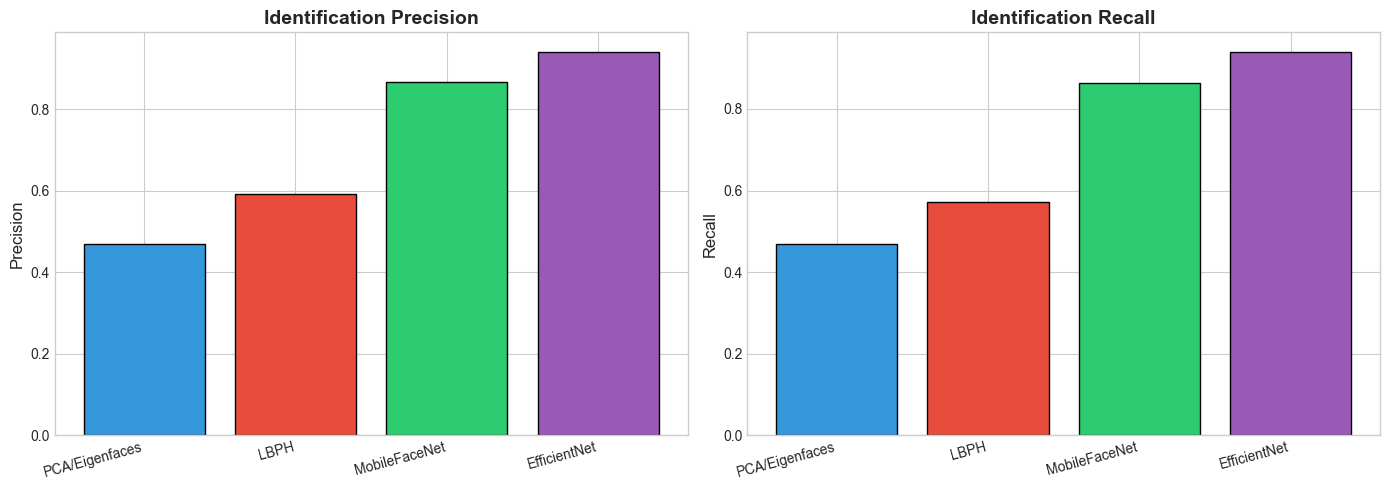

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
prec_vals = [results[m]['Identification Precision'] for m in models_list]
rec_vals = [results[m]['Identification Recall'] for m in models_list]
axes[0].bar(models_list, prec_vals, color=colors, edgecolor='black')
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Identification Precision', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(models_list, rotation=15, ha='right')
axes[1].bar(models_list, rec_vals, color=colors, edgecolor='black')
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Identification Recall', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(models_list, rotation=15, ha='right')
plt.tight_layout()
plt.savefig('precision_recall_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Custom Image Prediction

In [27]:
def test_custom_image_all_models(image_path, threshold_sim=0.5, threshold_lbph=90):
    print("="*80)
    print(f"TESTING CUSTOM IMAGE: {image_path}")
    print("="*80)
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return
    img_display = Image.open(image_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_display)
    plt.title('Test Image', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    predictions = {}
    
    print("\n--- 1. PCA/Eigenfaces Prediction ---")
    img_pca = Image.open(image_path).convert('L').resize((112, 112))
    x_pca = np.array(img_pca).flatten().astype(np.float32)
    x_pca = (x_pca - 127.5) / 128.0
    query_pca = (x_pca - pca_mean) @ pca_W
    query_pca = query_pca / np.linalg.norm(query_pca)
    sims_pca = np.dot(query_pca, train_feats_pca.T)
    idx_pca = np.argmax(sims_pca)
    sim_pca = sims_pca[idx_pca]
    pred_class_pca = y_train[idx_pca]
    print(f"   Predicted Class: {pred_class_pca} - {class_names[pred_class_pca]}")
    print(f"   Similarity: {sim_pca:.4f}")
    print(f"   Match: {'YES' if sim_pca > threshold_sim else 'NO'}")
    predictions['PCA/Eigenfaces'] = {'class': pred_class_pca, 'name': class_names[pred_class_pca], 'score': sim_pca}
    
    print("\n--- 2. LBPH Prediction ---")
    img_lbph = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_lbph = cv2.resize(img_lbph, (IMG_SIZE, IMG_SIZE))
    img_lbph = cv2.equalizeHist(img_lbph)
    label_lbph, conf_lbph = lbph.predict(img_lbph)
    print(f"   Predicted Class: {label_lbph} - {class_names[label_lbph]}")
    print(f"   Distance: {conf_lbph:.4f}")
    print(f"   Match: {'YES' if conf_lbph < threshold_lbph else 'NO'}")
    predictions['LBPH'] = {'class': label_lbph, 'name': class_names[label_lbph], 'score': -conf_lbph}
    
    print("\n--- 3. MobileFaceNet Prediction ---")
    img_mfn = test_transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        emb_mfn = mobilefacenet(img_mfn)
        emb_mfn = F.normalize(emb_mfn).cpu().numpy()
    sims_mfn = np.dot(emb_mfn, train_emb_mfn.T).squeeze()
    idx_mfn = np.argmax(sims_mfn)
    sim_mfn = sims_mfn[idx_mfn]
    pred_class_mfn = y_train[idx_mfn]
    print(f"   Predicted Class: {pred_class_mfn} - {class_names[pred_class_mfn]}")
    print(f"   Similarity: {sim_mfn:.4f}")
    print(f"   Match: {'YES' if sim_mfn > threshold_sim else 'NO'}")
    predictions['MobileFaceNet'] = {'class': pred_class_mfn, 'name': class_names[pred_class_mfn], 'score': sim_mfn}
    
    print("\n--- 4. EfficientNet Prediction ---")
    img_eff = test_transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        emb_eff = efficientnet(img_eff)
        emb_eff = F.normalize(emb_eff).cpu().numpy()
    sims_eff = np.dot(emb_eff, train_emb_eff.T).squeeze()
    idx_eff = np.argmax(sims_eff)
    sim_eff = sims_eff[idx_eff]
    pred_class_eff = y_train[idx_eff]
    print(f"   Predicted Class: {pred_class_eff} - {class_names[pred_class_eff]}")
    print(f"   Similarity: {sim_eff:.4f}")
    print(f"   Match: {'YES' if sim_eff > threshold_sim else 'NO'}")
    predictions['EfficientNet'] = {'class': pred_class_eff, 'name': class_names[pred_class_eff], 'score': sim_eff}
    
    print("\n" + "="*80)
    print("PREDICTION SUMMARY")
    print("="*80)
    print(f"{'Model':<20} {'Predicted Class':<20} {'Score':<15}")
    print("-"*55)
    for model, pred in predictions.items():
        print(f"{model:<20} {pred['name'][:18]:<20} {pred['score']:.4f}")
    print("="*80)
    return predictions

TESTING CUSTOM IMAGE: test_image1.jpg


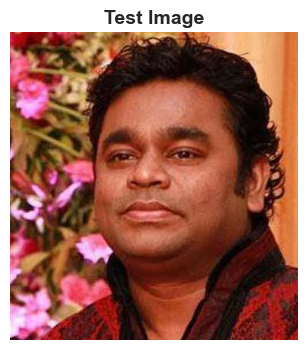


--- 1. PCA/Eigenfaces Prediction ---
   Predicted Class: 0 - class1
   Similarity: 0.5346
   Match: YES

--- 2. LBPH Prediction ---
   Predicted Class: 0 - class1
   Distance: 26.7173
   Match: YES

--- 3. MobileFaceNet Prediction ---
   Predicted Class: 0 - class1
   Similarity: 0.9817
   Match: YES

--- 4. EfficientNet Prediction ---
   Predicted Class: 0 - class1
   Similarity: 0.8405
   Match: YES

PREDICTION SUMMARY
Model                Predicted Class      Score          
-------------------------------------------------------
PCA/Eigenfaces       class1               0.5346
LBPH                 class1               -26.7173
MobileFaceNet        class1               0.9817
EfficientNet         class1               0.8405


In [28]:
custom_image_path = 'test_image1.jpg'
if os.path.exists(custom_image_path):
    predictions = test_custom_image_all_models(custom_image_path)
else:
    print(f"Custom image not found: {custom_image_path}")
    print("Please provide a valid image path to test.")

## 11. Conclusion

In [29]:
print("\n" + "="*80)
print("                           FINAL CONCLUSIONS")
print("="*80)
print("\nMODEL RANKING (by Rank-1 Accuracy):")
sorted_models = sorted(results.items(), key=lambda x: x[1]['Rank-1 Accuracy'], reverse=True)
for i, (model, metrics) in enumerate(sorted_models, 1):
    rank_marker = '[1st]' if i == 1 else ('[2nd]' if i == 2 else ('[3rd]' if i == 3 else f'[{i}th]'))
    print(f"   {rank_marker} {model}: {metrics['Rank-1 Accuracy']*100:.2f}%")

print("\nKEY OBSERVATIONS:")
print("   - Deep learning models (MobileFaceNet, EfficientNet) generally outperform")
print("     traditional methods (LBPH, PCA) for face recognition tasks.")
print("   - ArcFace loss significantly improves face verification performance.")
print("   - LBPH is computationally efficient but less accurate.")
print("   - PCA/Eigenfaces provides a good baseline for comparison.")
print("\nMETRICS EXPLANATION:")
print("   - Verification AUC: Area under ROC curve for same/different person pairs")
print("   - Rank-1 Accuracy: Correct identification rate using nearest neighbor")
print("   - MSE: Mean Squared Error between embeddings")
print("   - Precision/Recall/F1: Standard classification metrics")
print("\n" + "="*80)
print("                      ASSESSMENT COMPLETED SUCCESSFULLY!")
print("="*80)


                           FINAL CONCLUSIONS

MODEL RANKING (by Rank-1 Accuracy):
   [1st] EfficientNet: 94.06%
   [2nd] MobileFaceNet: 86.45%
   [3rd] LBPH: 57.22%
   [4th] PCA/Eigenfaces: 46.81%

KEY OBSERVATIONS:
   - Deep learning models (MobileFaceNet, EfficientNet) generally outperform
     traditional methods (LBPH, PCA) for face recognition tasks.
   - ArcFace loss significantly improves face verification performance.
   - LBPH is computationally efficient but less accurate.
   - PCA/Eigenfaces provides a good baseline for comparison.

METRICS EXPLANATION:
   - Verification AUC: Area under ROC curve for same/different person pairs
   - Rank-1 Accuracy: Correct identification rate using nearest neighbor
   - MSE: Mean Squared Error between embeddings
   - Precision/Recall/F1: Standard classification metrics

                      ASSESSMENT COMPLETED SUCCESSFULLY!
